# Enhancing CFSv2 Temperature Forecasts with Neural Network Models

## Prerequisites

This notebook assumes familiarity with Python programming and some basic understanding of machine learning and deep learning concepts. It also requires the following:
- Installation of necessary Python libraries (listed below).
- Set up and authenticate your Google Cloud Storage environment to access project-specific data stored in GCS buckets.
- Ensure access to the VERA observation data (`hourly-met-targets.csv.gz`) and other Parquet files in the specified GCS bucket (`adiabat-cmda`).

For detailed installation instructions, refer to the following:
- [Google Cloud Documentation](https://cloud.google.com/storage/docs) for working with GCS.

### Setup Instructions
1. **Install Required Libraries**  
   Use the following command to install all necessary libraries:
   ```bash
   !pip install pandas numpy scikit-learn tensorflow matplotlib seaborn google-cloud-storage pyarrow tqdm


In [1]:
# Core Libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computations

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Cloud Storage and Data Handling
from google.cloud import storage
import pyarrow.parquet as pq
import pyarrow as pa
import gcsfs

# Utilities
from io import BytesIO
import requests
from tqdm import tqdm
import concurrent.futures
import datetime

In [2]:
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Dec 07, 2024
==


## Forecast Parameters

In [3]:
#@title Select Forecast Horizon
#@markdown Adjust the `n_forecast` value to control the forecast period. Options are: 1, 14, 30, 90, 180, 270.

n_forecast = 180  #@param ["1", "14", "30", "90", "180", "270"] {type: "raw"}
#@markdown ---
print(f"Selected Forecast Horizon: {n_forecast} days")

Selected Forecast Horizon: 180 days


## Format VERA Real Observations

### Step 1: Gather VERA Observation Data

#### Dataset Overview
- **Project:** VERA4CAST (Virginia Ecological Research Archive)
- **Variable:** Mean Air Temperature 2 meters above sea level (AirTemp_C_mean)
- **Temporal Resolution:** Hourly measurements
- **Data Source:** RENC OSN XSEDE Repository
- **Location:** Falling Creek Reservoir (FCRE) Area

#### Data Retrieval and Processing
This notebook retrieves hourly meteorological target data, filtering specifically for mean air temperature measurements. The data is downloaded from a compressed CSV file and processed using pandas for further analysis.

In [4]:
## Gather VERA Observation Data of AirTemp_C_mean for FCRE Area
url = "https://renc.osn.xsede.org/bio230121-bucket01/vera4cast/targets/project_id=vera4cast/duration=PT1H/hourly-met-targets.csv.gz"

vera_df = pd.read_csv(url, compression='gzip')

observations_df = vera_df[vera_df['variable'] == 'AirTemp_C_mean']

observations_df.head(5)

,project_id,site_id,datetime,duration,depth_m,variable,observation
2,vera4cast,fcre,2024-01-01 05:00:00.000000Z,PT1H,NaN,AirTemp_C_mean,3.29
11,vera4cast,fcre,2024-01-01 06:00:00.000000Z,PT1H,NaN,AirTemp_C_mean,3.56
20,vera4cast,fcre,2024-01-01 07:00:00.000000Z,PT1H,NaN,AirTemp_C_mean,4.14
29,vera4cast,fcre,2024-01-01 08:00:00.000000Z,PT1H,NaN,AirTemp_C_mean,6.23
38,vera4cast,fcre,2024-01-01 09:00:00.000000Z,PT1H,NaN,AirTemp_C_mean,7.52


### Step 2: Prepare Data for Forecasting

In [5]:
## Format for N days in Advance for Training / Testing Output Sets
## Date: t
## Observation for a given date: observation(t)
## Pull:
## observation(t+1), observation(t+2), ..., observation(t+n_forecast)

observations_df = observations_df.copy()

observations_df['date'] = pd.to_datetime(observations_df['datetime']).dt.date

daily_mean = observations_df.groupby('date')['observation'].mean().reset_index()

daily_mean.head()

mean_out = daily_mean.copy()

for i in range(1, n_forecast + 1):
    mean_out[f'observation(t+{i})'] = mean_out['observation'].shift(-i)

mean_out.dropna(inplace=True)

mean_out.reset_index(drop=True, inplace=True)
mean_out = mean_out.drop(['observation'], axis=1)

<ipython-input-5-93befe96e733>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mean_out[f'observation(t+{i})'] = mean_out['observation'].shift(-i)
<ipython-input-5-93befe96e733>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mean_out[f'observation(t+{i})'] = mean_out['observation'].shift(-i)
<ipython-input-5-93befe96e733>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

### Step 3: Format Data for N-Day Forecast

In [6]:
## Set Date and datetime format index

mean_out['date'] = pd.to_datetime(mean_out['date'])
mean_out.set_index('date', inplace=True)
mean_out


,observation(t+1),observation(t+2),observation(t+3),observation(t+4),observation(t+5),observation(t+6),observation(t+7),observation(t+8),observation(t+9),observation(t+10),...,observation(t+171),observation(t+172),observation(t+173),observation(t+174),observation(t+175),observation(t+176),observation(t+177),observation(t+178),observation(t+179),observation(t+180)
date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,23.168750,25.734583,26.083750,23.052083,22.487500,22.329167,22.792083,22.870417,22.944167,22.529167,...,16.453333,14.650833,16.112917,10.857083,7.772083,10.533750,11.521667,5.173333,3.133333,5.092917
2015-07-08,25.734583,26.083750,23.052083,22.487500,22.329167,22.792083,22.870417,22.944167,22.529167,24.126667,...,14.650833,16.112917,10.857083,7.772083,10.533750,11.521667,5.173333,3.133333,5.092917,0.890000
2015-07-09,26.083750,23.052083,22.487500,22.329167,22.792083,22.870417,22.944167,22.529167,24.126667,26.047500,...,16.112917,10.857083,7.772083,10.533750,11.521667,5.173333,3.133333,5.092917,0.890000,-3.888750
2015-07-10,23.052083,22.487500,22.329167,22.792083,22.870417,22.944167,22.529167,24.126667,26.047500,26.075000,...,10.857083,7.772083,10.533750,11.521667,5.173333,3.133333,5.092917,0.890000,-3.888750,-3.753333
2015-07-11,22.487500,22.329167,22.792083,22.870417,22.944167,22.529167,24.126667,26.047500,26.075000,24.668333,...,7.772083,10.533750,11.521667,5.173333,3.133333,5.092917,0.890000,-3.888750,-3.753333,-0.111667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-06,22.302500,20.454167,21.945417,19.617083,18.095417,18.767500,21.445417,23.037917,22.874167,22.311667,...,7.733750,10.497500,12.533750,6.527500,8.119583,2.813750,-0.474167,0.810000,-1.682917,-2.875000
2024-06-07,20.454167,21.945417,19.617083,18.095417,18.767500,21.445417,23.037917,22.874167,22.311667,23.656667,...,10.497500,12.533750,6.527500,8.119583,2.813750,-0.474167,0.810000,-1.682917,-2.875000,-2.900833
2024-06-08,21.945417,19.617083,18.095417,18.767500,21.445417,23.037917,22.874167,22.311667,23.656667,23.250833,...,12.533750,6.527500,8.119583,2.813750,-0.474167,0.810000,-1.682917,-2.875000,-2.900833,0.904583


## Pull Data from Parquet Files in Cloud

### Step 1: Authenticate and Initialize GCS Client

In [7]:
from google.colab import auth
auth.authenticate_user()
from datetime import timedelta
import io
from google.cloud import storage

### Step 2: Define File Processing Function

In [8]:
# Initialize Google Cloud client
client = storage.Client()

# Shared bucket name
BUCKET_NAME = 'adiabat-cmda'

# Initialize GCSFileSystem
fs = gcsfs.GCSFileSystem()

# Function to process each file
def process_file(file):

    # Extract reference datetime from the filename
    ref_date_time_str = file.split('.')[0][-8:]  # Assumes last 8 chars represent date in 'YYYYMMDD' format
    ref_date_time = pd.to_datetime(ref_date_time_str, format='%Y%m%d')

    # Define min and max datetime for filtering
    min_date = (ref_date_time + timedelta(days=1))
    max_date = (ref_date_time + timedelta(days=n_forecast))

    # Step 1: Use a rough filter to narrow down rows by reference_datetime date
    filters = [
        # Assuming midnight reference
        ('reference_datetime', '=', ref_date_time.strftime('%Y-%m-%d 00:00')),
        ('datetime', '>=', min_date.strftime('%Y-%m-%d 00:00')),
        ('datetime', '<=', max_date.strftime('%Y-%m-%d 23:00'))
    ]

    return pd.read_parquet(io.BytesIO(fs.cat(f'{BUCKET_NAME}/{file}')), filters=filters)

### Step 3: Process All Parquet Files in the GCS Bucket


#### Data Processing Pipeline
- **Platform:** Google Cloud Storage
- **Data Type:** Parquet Forecast Files
- **Bucket:** 'adiabat-cmda'
- **Processing Method:** Concurrent File Filtering

#### Processing Overview
This script performs parallel processing of multiple Parquet files from a Google Cloud Storage bucket. Key operations include:
- Authentication with Google Cloud
- Dynamic file filtering based on reference datetime
- Concurrent file processing using ThreadPoolExecutor
- Consolidation of filtered forecast data

In [9]:
# List all Parquet files across the entire bucket
parquet_files = [blob.name for blob in client.list_blobs(BUCKET_NAME) if blob.name.endswith('.parquet')]

filtered_tables = [None] * len(parquet_files)


def process_and_store_file(index, file_name):
    try:
        result = process_file(file_name)  # Assuming process_file correctly returns a DataFrame or filtered data
        return index, result
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return index, None

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map each file and index to the executor
    futures = {executor.submit(process_and_store_file, i, file): i for i, file in enumerate(parquet_files)}

    # Use tqdm to show a progress bar for the number of files being processed
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Files"):
        index, result = future.result()
        filtered_tables[index] = result

# Flatten filtered_tables to remove any None entries, if needed
filtered_tables = [table for table in filtered_tables if table is not None]

# Combine all individual DataFrames into one, if each result is a DataFrame
predictions_df = pd.concat(filtered_tables, ignore_index=True)
# reference date time object
predictions_df['reference_datetime'] = pd.to_datetime(predictions_df['reference_datetime'])
predictions_df['datetime'] = pd.to_datetime(predictions_df['datetime'])
display(predictions_df.head())

Processing Files: 100%|██████████| 2225/2225 [01:41<00:00, 22.03it/s]


,reference_datetime,datetime,parameter,prediction,variable,site_id,duration
0,2018-12-01,2018-12-02 00:00:00,1,8.371,Temp_C_2m,fcre,PT1H
1,2018-12-01,2018-12-02 06:00:00,1,9.051,Temp_C_2m,fcre,PT1H
2,2018-12-01,2018-12-02 12:00:00,1,11.743,Temp_C_2m,fcre,PT1H
3,2018-12-01,2018-12-02 18:00:00,1,16.169,Temp_C_2m,fcre,PT1H
4,2018-12-01,2018-12-03 00:00:00,1,10.431,Temp_C_2m,fcre,PT1H


## Preparing Data and Training Models for N-Day Temperature Forecasts


### Step 1: Organize Data for N-Day Prediction

In [10]:
## Organize data in following format
## reference_datetime | t+1 ensemble1 | t+1 ensemble1 | ... | t+n ensemble4

predictions_df['time_delta_days'] = (predictions_df['datetime'] - predictions_df['reference_datetime']).dt.days

merged_df = predictions_df.groupby(['reference_datetime', 'time_delta_days']).agg({'prediction': 'mean'}).reset_index()

merged_df = merged_df.pivot_table(
    index='reference_datetime',
    columns='time_delta_days',
    values='prediction',
    aggfunc='mean'
)


merged_df.columns = [f"t+{day} mu" for day in merged_df.columns]
merged_df = merged_df.reset_index()


merged_df['reference_datetime'] = pd.to_datetime(merged_df['reference_datetime'])
merged_df.set_index('reference_datetime', inplace=True)

merged_df.head(5)


,t+1 mu,t+2 mu,t+3 mu,t+4 mu,t+5 mu,t+6 mu,t+7 mu,t+8 mu,t+9 mu,t+10 mu,...,t+171 mu,t+172 mu,t+173 mu,t+174 mu,t+175 mu,t+176 mu,t+177 mu,t+178 mu,t+179 mu,t+180 mu
reference_datetime,,,,,,,,,,,,,,,,,,,,,
2018-11-02,9.137125,5.176375,5.174688,12.005250,13.499063,6.135125,3.951125,5.796250,7.674875,11.657000,...,4.05725,3.85050,8.01900,10.70775,7.34900,8.00400,12.75450,9.03275,10.24100,16.77625
2018-11-03,4.841812,7.193125,11.433312,13.958750,6.751250,4.707625,3.551687,3.693688,4.468187,7.221875,...,11.75425,15.54175,13.90525,14.92475,16.88225,17.07725,17.50625,18.50250,19.08750,19.53025
2018-11-04,10.305687,12.893500,12.993625,5.844938,4.187062,4.351875,3.031188,2.267250,5.368937,6.129625,...,6.94825,10.79175,11.31675,13.77550,14.37850,15.29800,16.38350,12.33175,8.84825,11.53925
2018-11-05,13.861125,10.960625,9.373313,6.034313,6.587063,3.037500,4.100000,5.957000,6.581563,5.687812,...,6.37850,10.06500,7.55925,6.06150,5.10900,4.97750,7.00350,9.79450,9.09950,7.42175
2018-11-06,11.046938,8.995375,5.764312,3.602125,-0.805312,0.349375,3.442375,8.117750,7.536437,4.551625,...,7.79625,9.52600,13.12775,15.60225,9.15325,13.63775,11.66850,6.50300,8.85825,11.97400


In [11]:
mean_out.index = pd.to_datetime(mean_out.index)
mean_out_shifted = mean_out.copy()

mean_out_shifted.index = mean_out_shifted.index + pd.Timedelta(days=n_forecast)

merged_df = pd.merge(merged_df, mean_out_shifted, left_on='reference_datetime', right_index=True, how='left')

merged_df.head()

,t+1 mu,t+2 mu,t+3 mu,t+4 mu,t+5 mu,t+6 mu,t+7 mu,t+8 mu,t+9 mu,t+10 mu,...,observation(t+171),observation(t+172),observation(t+173),observation(t+174),observation(t+175),observation(t+176),observation(t+177),observation(t+178),observation(t+179),observation(t+180)
reference_datetime,,,,,,,,,,,,,,,,,,,,,
2018-11-02,9.137125,5.176375,5.174688,12.005250,13.499063,6.135125,3.951125,5.796250,7.674875,11.657000,...,9.900000,6.997083,6.299167,9.424583,10.770833,11.761667,10.821667,15.662917,16.079167,17.275417
2018-11-03,4.841812,7.193125,11.433312,13.958750,6.751250,4.707625,3.551687,3.693688,4.468187,7.221875,...,6.997083,6.299167,9.424583,10.770833,11.761667,10.821667,15.662917,16.079167,17.275417,10.438333
2018-11-04,10.305687,12.893500,12.993625,5.844938,4.187062,4.351875,3.031188,2.267250,5.368937,6.129625,...,6.299167,9.424583,10.770833,11.761667,10.821667,15.662917,16.079167,17.275417,10.438333,7.680000
2018-11-05,13.861125,10.960625,9.373313,6.034313,6.587063,3.037500,4.100000,5.957000,6.581563,5.687812,...,9.424583,10.770833,11.761667,10.821667,15.662917,16.079167,17.275417,10.438333,7.680000,12.870833
2018-11-06,11.046938,8.995375,5.764312,3.602125,-0.805312,0.349375,3.442375,8.117750,7.536437,4.551625,...,10.770833,11.761667,10.821667,15.662917,16.079167,17.275417,10.438333,7.680000,12.870833,14.867500


### Step 2: Split Data into Training and Testing Sets

In [ ]:
# Split into training and test sets (80-20 split)
split_index = int(len(merged_df) * 0.8)
train_df = merged_df.iloc[:split_index]
test_df = merged_df.iloc[split_index:]

from datetime import datetime, timedelta

train_start = "2018-11-02"

test_start = "2024-03-02"

ts_date = datetime.strptime(train_end, "%Y-%m-%d")
te_date = ts_date + timedelta(days=n_forecast)
test_start = te_date.strftime("%Y-%m-%d")

test_start_date = datetime.strptime(test_start, "%Y-%m-%d")
test_end_date = test_start_date + timedelta(days=n_forecast)
test_end = test_end_date.strftime("%Y-%m-%d")

x_train = merged_df.loc[train_start:train_end].dropna().values
y_train = mean_out.loc[train_start:train_end].dropna().values
x_test = merged_df.loc[test_start:test_end].dropna().values
y_test = mean_out.loc[test_start:test_end].dropna().values

### Step 3: Train Feedforward Neural Network (FNN)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Define the FNN model
fnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dense(256, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(128, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(n_forecast)
])

# Compile the FNN model
fnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')

history = fnn_model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11.1368 - val_loss: 4.7062
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1664 - val_loss: 3.6196
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3199 - val_loss: 3.4088
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1782 - val_loss: 3.4205
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1283 - val_loss: 3.4510
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1004 - val_loss: 3.3245
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0997 - val_loss: 3.4343
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1061 - val_loss: 3.6406
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0914 - val_loss: 3.4226
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0567 - val_loss: 3.4134
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0274 - val_loss: 3.5224
Epoch 12/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0315 - va

## Evaluate Model Performance and Visualize Predictions

### 1. FNN Model Performance on Testing Set

In [14]:
predictionsf = fnn_model.predict(x_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test[0], predictionsf[0])
mse = mean_squared_error(y_test[0], predictionsf[0])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Absolute Error (MAE): 4.0767665550797085
Mean Squared Error (MSE): 25.49309598228939
Root Mean Squared Error (RMSE): 5.049068823287061


### Visualizing N-Day Forecasts: Observed vs. Predictions

In [15]:
test_df = predictions_df.pivot_table(
    index='reference_datetime',  # Rows grouped by reference datetime
    columns=['time_delta_days', 'parameter'],  # Columns split by time_delta and parameter
    values='prediction'  # Values in the pivot table
)

test_df.columns = [f"t+{day} parameter{param}" for day, param in test_df.columns]
test_df = test_df.reset_index()  # Reset index to make reference_datetime a column

test_df['reference_datetime'] = pd.to_datetime(test_df['reference_datetime'])
test_df.set_index('reference_datetime', inplace=True)
test_df.head(5)

,t+1 parameter1,t+1 parameter2,t+1 parameter3,t+1 parameter4,t+2 parameter1,t+2 parameter2,t+2 parameter3,t+2 parameter4,t+3 parameter1,t+3 parameter2,...,t+171 parameter1,t+172 parameter1,t+173 parameter1,t+174 parameter1,t+175 parameter1,t+176 parameter1,t+177 parameter1,t+178 parameter1,t+179 parameter1,t+180 parameter1
reference_datetime,,,,,,,,,,,,,,,,,,,,,
2018-11-02,8.84650,10.03775,8.34625,9.31800,5.00275,5.68350,4.84850,5.17075,5.22350,4.85950,...,4.05725,3.85050,8.01900,10.70775,7.34900,8.00400,12.75450,9.03275,10.24100,16.77625
2018-11-03,4.58350,5.29750,4.40375,5.08250,6.90150,7.53525,6.31650,8.01925,11.37975,10.33725,...,11.75425,15.54175,13.90525,14.92475,16.88225,17.07725,17.50625,18.50250,19.08750,19.53025
2018-11-04,10.09350,10.93000,10.57750,9.62175,12.92000,12.18000,14.88225,11.59175,12.39625,14.69125,...,6.94825,10.79175,11.31675,13.77550,14.37850,15.29800,16.38350,12.33175,8.84825,11.53925
2018-11-05,14.43850,13.31525,15.06050,12.63025,10.58550,12.09175,10.45900,10.70625,10.08125,8.77125,...,6.37850,10.06500,7.55925,6.06150,5.10900,4.97750,7.00350,9.79450,9.09950,7.42175
2018-11-06,10.55825,12.07575,10.08150,11.47225,9.36175,8.28300,10.08225,8.25450,5.82175,5.33675,...,7.79625,9.52600,13.12775,15.60225,9.15325,13.63775,11.66850,6.50300,8.85825,11.97400


In [16]:
e1 = test_df[[f't+{i} parameter1' for i in range(1, n_forecast + 1)]]
e2 = test_df[[f't+{i} parameter2' for i in range(1, min(n_forecast + 1, 91))]]
e3 = test_df[[f't+{i} parameter3' for i in range(1, min(n_forecast + 1, 91))]]
e4 = test_df[[f't+{i} parameter4' for i in range(1, min(n_forecast + 1, 91))]]

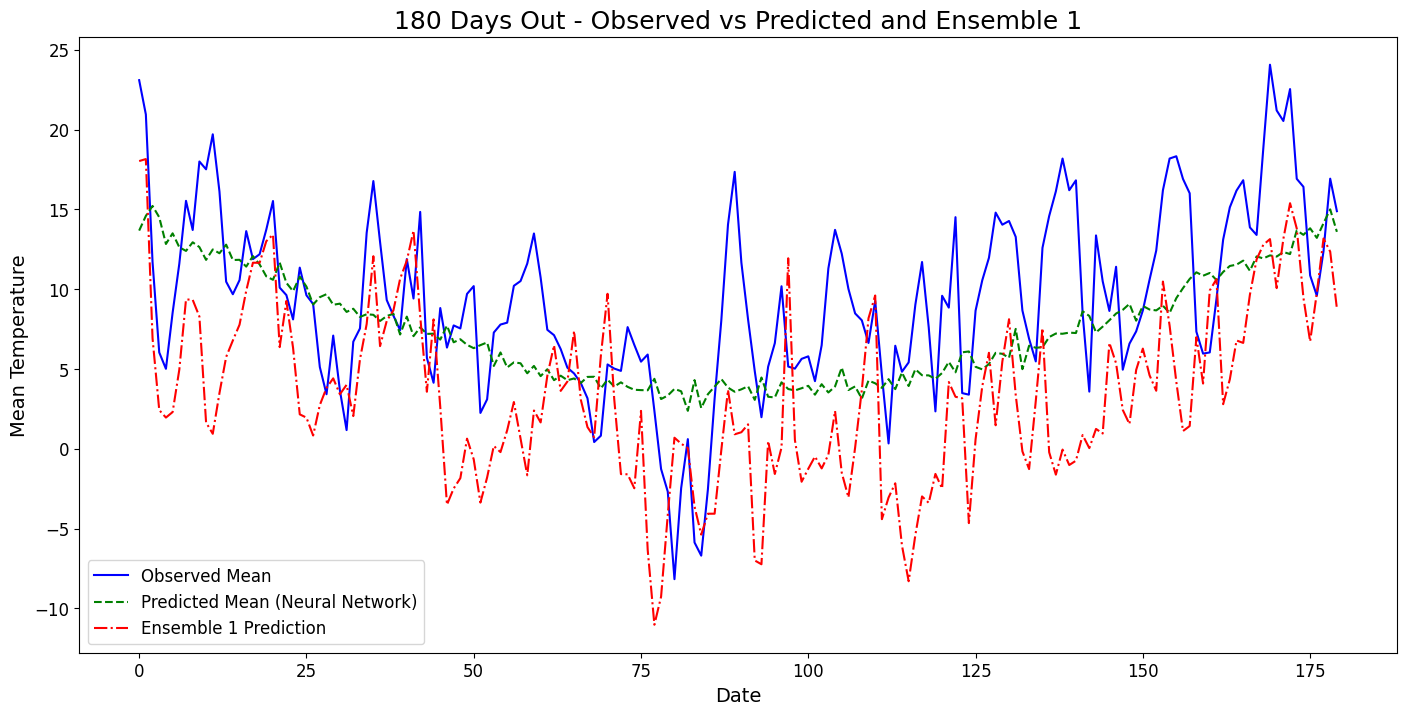

In [17]:
import matplotlib.pyplot as plt

dates = range(len(y_test[0]))

if n_forecast > 90:
    # Single plot for n_forecast >= 90
    plt.figure(figsize=(17, 8))
    plt.plot(dates, y_test[0], label='Observed Mean', color='blue')
    plt.plot(dates, predictionsf[0], label='Predicted Mean (Neural Network)', color='green', linestyle='--')
    plt.plot(dates, e1.loc[test_start], label='Ensemble 1 Prediction', color='red', linestyle='-.')

    # Customize plot appearance
    plt.title(f'{n_forecast} Days Out - Observed vs Predicted and Ensemble 1', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Temperature', fontsize=14)
    plt.legend(fontsize=12)

    # Increase the font size for tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()
else:
    # Subplots for n_forecast < 90
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))  # 2x2 grid of subplots
    axs = axs.ravel()  # Flatten the axes array for easier indexing

    # Plot 1: Observed, Predicted, and Ensemble 1
    axs[0].plot(dates, y_test[0], label='Observed Mean', color='blue')
    axs[0].plot(dates, predictionsf[0], label='Predicted Mean (Neural Network)', color='green', linestyle='-.')
    axs[0].plot(dates, e1.loc[test_start], label='Ensemble 1 Prediction', color='red', linestyle='--')
    axs[0].set_title(f'{n_forecast} Days Out - Observed, Predicted, and Ensemble 1', fontsize=16)
    axs[0].set_xlabel('Date', fontsize=14)
    axs[0].set_ylabel('Mean Temperature', fontsize=14)
    axs[0].legend(fontsize=12)

    # Plot 2: Observed, Predicted, and Ensemble 2
    axs[1].plot(dates, y_test[0], label='Observed Mean', color='blue')
    axs[1].plot(dates, predictionsf[0], label='Predicted Mean (Neural Network)', color='green', linestyle='-.')
    axs[1].plot(dates, e2.loc[test_start], label='Ensemble 2 Prediction', color='mediumvioletred', linestyle='--')
    axs[1].set_title(f'{n_forecast} Days Out - Observed, Predicted, and Ensemble 2', fontsize=16)
    axs[1].set_xlabel('Date', fontsize=14)
    axs[1].set_ylabel('Mean Temperature', fontsize=14)
    axs[1].legend(fontsize=12)

    # Plot 3: Observed, Predicted, and Ensemble 3
    axs[2].plot(dates, y_test[0], label='Observed Mean', color='blue')
    axs[2].plot(dates, predictionsf[0], label='Predicted Mean (Neural Network)', color='green', linestyle='-.')
    axs[2].plot(dates, e3.loc[test_start], label='Ensemble 3 Prediction', color='salmon', linestyle='--')
    axs[2].set_title(f'{n_forecast} Days Out - Observed, Predicted, and Ensemble 3', fontsize=16)
    axs[2].set_xlabel('Date', fontsize=14)
    axs[2].set_ylabel('Mean Temperature', fontsize=14)
    axs[2].legend(fontsize=12)

    # Plot 4: Observed, Predicted, and Ensemble 4
    axs[3].plot(dates, y_test[0], label='Observed Mean', color='blue')
    axs[3].plot(dates, predictionsf[0], label='Predicted Mean (Neural Network)', color='green', linestyle='-.')
    axs[3].plot(dates, e4.loc[test_start], label='Ensemble 4 Prediction', color='maroon', linestyle='--')
    axs[3].set_title(f'{n_forecast} Days Out - Observed, Predicted, and Ensemble 4', fontsize=16)
    axs[3].set_xlabel('Date', fontsize=14)
    axs[3].set_ylabel('Mean Temperature', fontsize=14)
    axs[3].legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()


### 3. Compare Ensemble Predictions with FNN Output

In [18]:
# Calculate RMSE for ensemble 1
ensemble1_predictions = e1.loc["2024-01-02"]
mae_ensemble1 = mean_absolute_error(y_test[0], ensemble1_predictions)
mse_ensemble1 = mean_squared_error(y_test[0], ensemble1_predictions)
rmse_ensemble1 = np.sqrt(mse_ensemble1)

# Calculate RMSE for neural network predictions
mae_nn = mean_absolute_error(y_test[0], predictionsf[0])
mse_nn = mean_squared_error(y_test[0], predictionsf[0])
rmse_nn = np.sqrt(mse_nn)

if (n_forecast <= 90):
  ensemble2_predictions = e2.loc["2024-01-02"]
  mae_ensemble2 = mean_absolute_error(y_test[0], ensemble2_predictions)
  mse_ensemble2 = mean_squared_error(y_test[0], ensemble2_predictions)
  rmse_ensemble2 = np.sqrt(mse_ensemble2)

  ensemble3_predictions = e3.loc["2024-01-02"]
  mae_ensemble3 = mean_absolute_error(y_test[0], ensemble3_predictions)
  mse_ensemble3 = mean_squared_error(y_test[0], ensemble3_predictions)
  rmse_ensemble3 = np.sqrt(mse_ensemble3)

  ensemble4_predictions = e4.loc["2024-01-02"]
  mae_ensemble4 = mean_absolute_error(y_test[0], ensemble4_predictions)
  mse_ensemble4 = mean_squared_error(y_test[0], ensemble4_predictions)
  rmse_ensemble4 = np.sqrt(mse_ensemble4)

  # Create a DataFrame to store the results
  results = pd.DataFrame({
      'Model': ['Neural Network', 'Ensemble 1', 'Ensemble 2', 'Ensemble 3', 'Ensemble 4'],
      'MAE': [mae_nn, mae_ensemble1, mae_ensemble2, mae_ensemble3, mae_ensemble4],
      'MSE': [mse_nn, mse_ensemble1, mse_ensemble2, mse_ensemble3, mse_ensemble4],
      'RMSE': [rmse_nn, rmse_ensemble1, rmse_ensemble2, rmse_ensemble3, rmse_ensemble4]
  })

else:
  # Create a DataFrame to store the results
  results = pd.DataFrame({
      'Model': ['Neural Network', 'Ensemble 1'],
      'MAE': [mae_nn, mae_ensemble1],
      'MSE': [mse_nn, mse_ensemble1],
      'RMSE': [rmse_nn, rmse_ensemble1]
  })

# Display the table
print(results)

            Model       MAE         MSE       RMSE
0  Neural Network  4.076767   25.493096   5.049069
1      Ensemble 1  8.572944  109.986143  10.487428


### 4. Predict Most Recent N-Day Forecast

In [19]:
next = merged_df.loc[mean_out.index.max()]
nextmonth = fnn_model.predict(next.values.reshape(1, -1))
nextmonth = nextmonth.reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


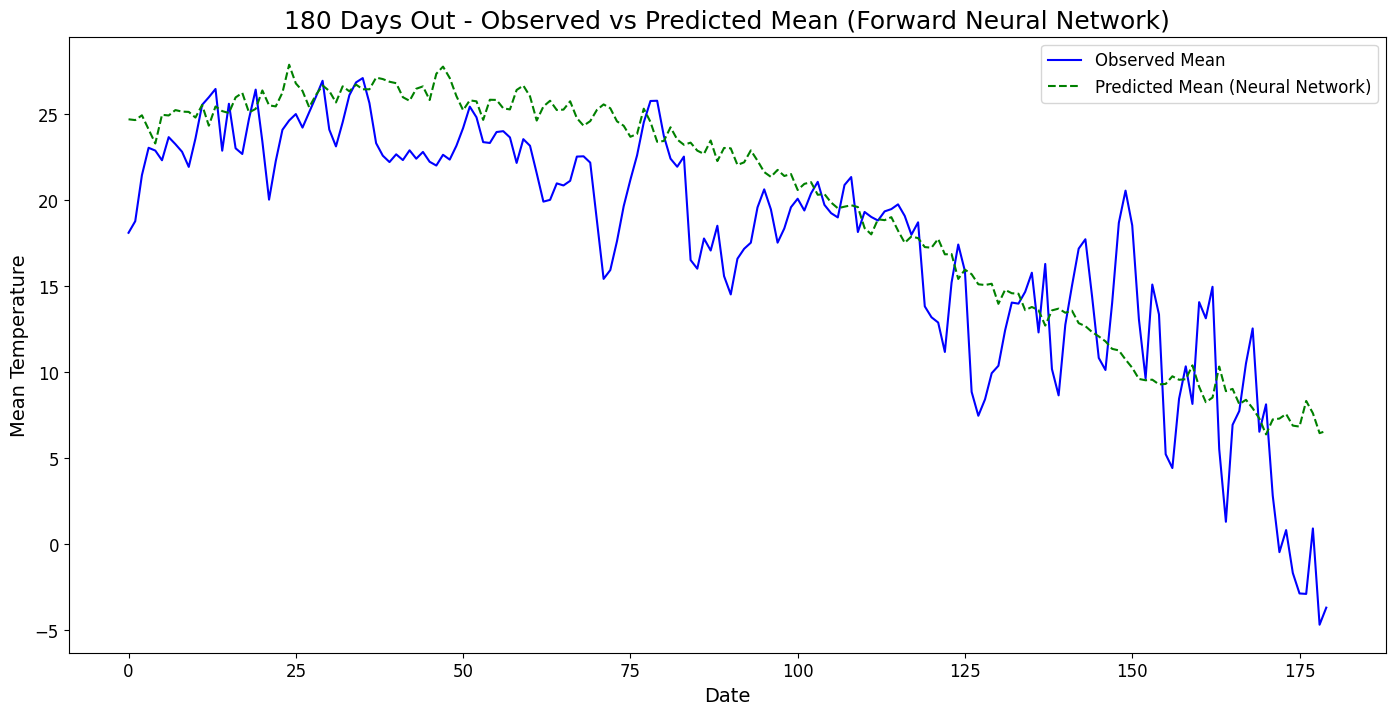

In [20]:
# Create the plot
dates = range(len(y_test[0]))
nexty = mean_out.loc[mean_out.index.max()]

plt.figure(figsize=(17, 8))
plt.plot(dates, nexty, label='Observed Mean', color='blue')
plt.plot(dates, nextmonth, label='Predicted Mean (Neural Network)', color='green', linestyle='--')

# Customize plot appearance
plt.title(f'{n_forecast} Days Out - Observed vs Predicted Mean (Forward Neural Network)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Temperature', fontsize=14)
plt.legend(fontsize=12)

# Increase the font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()